In [ ]:
QUESTION 1

In [ ]:
Q1 PART A

In [51]:
import warnings
warnings.filterwarnings("ignore")


In [50]:
import numpy as np
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


from sklearn.feature_extraction.text import TfidfVectorizer


In [5]:
df = pd.read_csv("spam.csv", encoding="latin-1")
df.head(), df.columns


(     v1                                                 v2 Unnamed: 2  \
 0   ham  Go until jurong point, crazy.. Available only ...        NaN   
 1   ham                      Ok lar... Joking wif u oni...        NaN   
 2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
 3   ham  U dun say so early hor... U c already then say...        NaN   
 4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   
 
   Unnamed: 3 Unnamed: 4  
 0        NaN        NaN  
 1        NaN        NaN  
 2        NaN        NaN  
 3        NaN        NaN  
 4        NaN        NaN  ,
 Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object'))

In [6]:
df = df[['v1', 'v2']].copy()
df.columns = ['label', 'text']

df.dropna(subset=['label', 'text'], inplace=True)

df.head()


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
label_mapping = {'ham': 0, 'spam': 1}
df['label_num'] = df['label'].map(label_mapping)

df[['label', 'label_num']].head()


,label,label_num
0,ham,0
1,ham,0
2,spam,1
3,ham,0
4,ham,0


In [8]:
# Count of each class
print("Class counts:")
print(df['label_num'].value_counts())

print("\nClass proportions:")
print(df['label_num'].value_counts(normalize=True))


Class counts:
label_num
0    4825
1     747
Name: count, dtype: int64

Class proportions:
label_num
0    0.865937
1    0.134063
Name: proportion, dtype: float64


In [17]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = ENGLISH_STOP_WORDS   # using sklearn stopwords

def preprocess_text(text):
    text = text.lower()  # lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    
    # tokenization + stopword removal
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

# apply to dataset
df['text_clean'] = df['text'].astype(str).apply(preprocess_text)
df[['text','text_clean']].head()


,text,text_clean
0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,u dun say early hor u c say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # uni+bi-grams

X = tfidf.fit_transform(df['text_clean'])
y = df['label_num'].values

X.shape, y.shape


((5572, 5000), (5572,))

In [ ]:
Q1 PART B

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((4457, 5000), (1115, 5000))

In [20]:
from sklearn.tree import DecisionTreeClassifier

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_pred_train = stump.predict(X_train)
y_pred_test  = stump.predict(X_test)


In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy :", accuracy_score(y_test, y_pred_test))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


Train Accuracy: 0.8900605788647072
Test Accuracy : 0.8860986547085202

Confusion Matrix:
[[961   5]
 [122  27]]


PART C

In [27]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

T = 15  # boosting rounds

n = X_train.shape[0]
weights = np.full(n, 1/n)  # equal initial weights

alphas = []
errors = []
models = []


In [28]:
for t in range(1, T+1):

    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=weights)
    
    pred = stump.predict(X_train)
    misclassified = (pred != y_train)
    
    error = np.sum(weights[misclassified])
    error = max(error, 1e-10)   # avoids division by zero
    
    alpha = 0.5 * np.log((1-error)/error)
    
    # update weights
    weights[misclassified] *= np.exp(alpha)
    weights[~misclassified] *= np.exp(-alpha)
    weights /= weights.sum()   # normalize
    
    # store for later
    alphas.append(alpha)
    errors.append(error)
    models.append(stump)

    print(f"\nIteration {t}")
    print("Misclassified sample indices:", np.where(misclassified)[0][:10], "...")
    print("Error:", round(error,4),
          " | Alpha:", round(alpha,4))
    print("Weights of first 10 samples:", weights[:10])



Iteration 1
Misclassified sample indices: [ 9 15 22 31 39 49 59 66 76 88] ...
Error: 0.1099  | Alpha: 1.0457
Weights of first 10 samples: [0.00012604 0.00012604 0.00012604 0.00012604 0.00012604 0.00012604
 0.00012604 0.00012604 0.00012604 0.00102041]

Iteration 2
Misclassified sample indices: [ 9 15 22 31 39 49 50 59 62 66] ...
Error: 0.4264  | Alpha: 0.1483
Weights of first 10 samples: [0.00010986 0.00010986 0.00010986 0.00010986 0.00010986 0.00010986
 0.00010986 0.00010986 0.00010986 0.00119661]

Iteration 3
Misclassified sample indices: [ 0  1  2  3  4  5  6  7  8 10] ...
Error: 0.4294  | Alpha: 0.1421
Weights of first 10 samples: [0.00012792 0.00012792 0.00012792 0.00012792 0.00012792 0.00012792
 0.00012792 0.00012792 0.00012792 0.00104859]

Iteration 4
Misclassified sample indices: [15 31 39 49 50 59 66 76 86 88] ...
Error: 0.41  | Alpha: 0.182
Weights of first 10 samples: [0.0001084 0.0001084 0.0001084 0.0001084 0.0001084 0.0001084 0.0001084
 0.0001084 0.0001084 0.0008886]

Iter

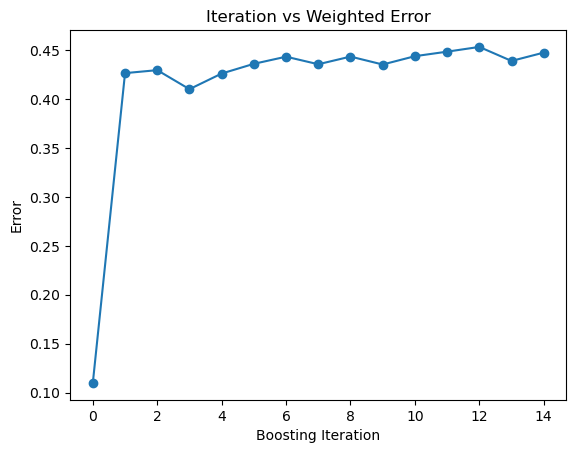

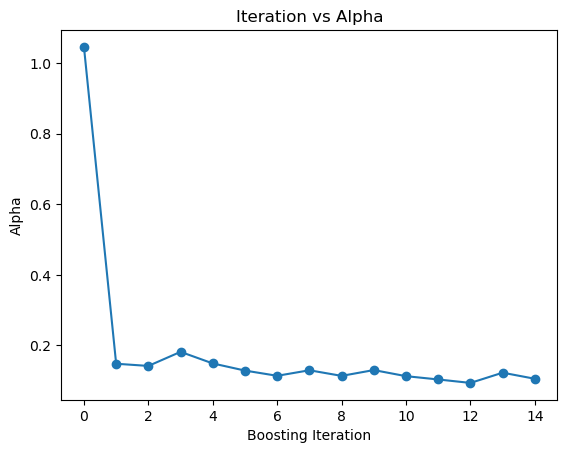

In [29]:
import matplotlib.pyplot as plt

plt.plot(errors, marker='o')
plt.title("Iteration vs Weighted Error")
plt.xlabel("Boosting Iteration")
plt.ylabel("Error")
plt.show()

plt.plot(alphas, marker='o')
plt.title("Iteration vs Alpha")
plt.xlabel("Boosting Iteration")
plt.ylabel("Alpha")
plt.show()


In [30]:
def predict_boost(X):
    final = np.zeros(X.shape[0])
    for alpha, model in zip(alphas, models):
        p = model.predict(X)
        p = np.where(p==1, 1, -1)
        final += alpha * p
    return np.where(final > 0, 1, 0)


In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score

train_pred = predict_boost(X_train)
test_pred  = predict_boost(X_test)

print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Test Accuracy :", accuracy_score(y_test, test_pred))
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, test_pred))


Train Accuracy: 0.8916311420237828
Test Accuracy : 0.8860986547085202

Confusion Matrix (Test):
[[961   5]
 [122  27]]


PART D

In [34]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_sklearn = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # updated parameter
    n_estimators=100,
    learning_rate=0.6,
    random_state=42
)


In [35]:
ada_sklearn.fit(X_train, y_train)

y_pred_train = ada_sklearn.predict(X_train)
y_pred_test  = ada_sklearn.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy :", accuracy_score(y_test, y_pred_test))
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test))


Train Accuracy: 0.9001570563159076
Test Accuracy : 0.9049327354260089

Confusion Matrix (Test):
[[966   0]
 [106  43]]


QUESTION 2 - HEART DISEASE DATASET

Q2 PART A

In [43]:
import pandas as pd
df = pd.read_csv("heart_disease_uci.csv")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y = (df['num'] > 0).astype(int)
X = df.drop(['id','dataset','num'], axis=1)

X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.median(numeric_only=True))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)



In [44]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

p_train = stump.predict(X_train)
p_test = stump.predict(X_test)


In [45]:
print("Train Acc:", accuracy_score(y_train, p_train))
print("Test Acc:", accuracy_score(y_test, p_test))
print(confusion_matrix(y_test, p_test))
print(classification_report(y_test, p_test))


Train Acc: 0.6929347826086957
Test Acc: 0.6956521739130435
[[73  9]
 [47 55]]
              precision    recall  f1-score   support

           0       0.61      0.89      0.72        82
           1       0.86      0.54      0.66       102

    accuracy                           0.70       184
   macro avg       0.73      0.71      0.69       184
weighted avg       0.75      0.70      0.69       184



Single stump is weak because one split cannot capture complex interactions in medical features.


Q2 PART B 

In [52]:
from sklearn.ensemble import AdaBoostClassifier

n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]

results = {}

for lr in learning_rates:
    accs = []
    for n in n_estimators_list:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
            n_estimators=n,
            learning_rate=lr,
            algorithm='SAMME',
            random_state=42
        )
        model.fit(X_train, y_train)
        accs.append(model.score(X_test, y_test))
    results[lr] = accs


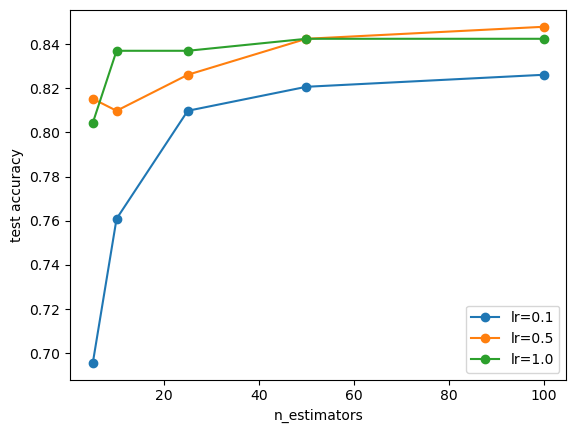

In [53]:
import matplotlib.pyplot as plt

for lr in learning_rates:
    plt.plot(n_estimators_list, results[lr], marker='o', label=f'lr={lr}')

plt.xlabel("n_estimators")
plt.ylabel("test accuracy")
plt.legend()
plt.show()


In [54]:
best_lr = None
best_n = None
best_acc = 0

for lr in learning_rates:
    for n, acc in zip(n_estimators_list, results[lr]):
        if acc > best_acc:
            best_acc = acc
            best_lr = lr
            best_n = n

print("Best lr:", best_lr)
print("Best n_estimators:", best_n)
print("Best test acc:", best_acc)


Best lr: 0.5
Best n_estimators: 100
Best test acc: 0.8478260869565217


Q2 PART C

In [55]:
best_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=best_n,
    learning_rate=best_lr,
    algorithm='SAMME',
    random_state=42
)

best_model.fit(X_train, y_train)

weak_errors = best_model.estimator_errors_

alphas = best_model.estimator_weights_
w = np.ones(len(y_train)) / len(y_train)

for t in range(best_n):
    h = best_model.estimators_[t]
    pred = h.predict(X_train)
    mis = (pred != y_train)
    a = alphas[t]
    w[mis] *= np.exp(a)
    w[~mis] *= np.exp(-a)
    w /= w.sum()

final_weights = w


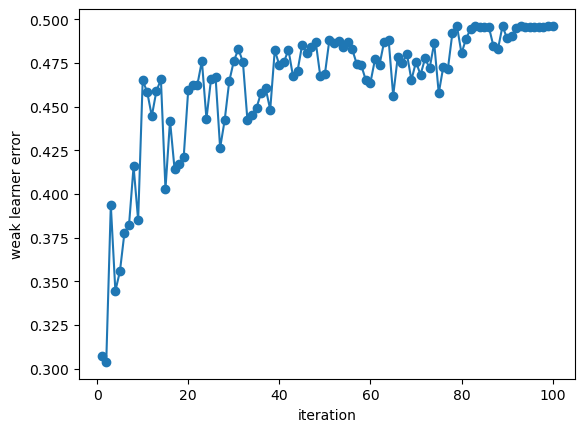

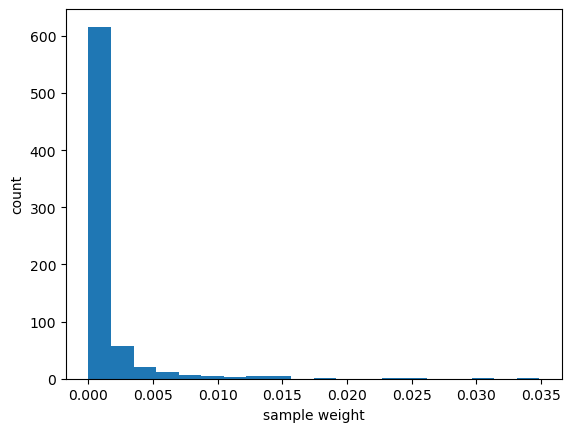

In [56]:
plt.plot(range(1, best_n+1), weak_errors, marker='o')
plt.xlabel("iteration")
plt.ylabel("weak learner error")
plt.show()

plt.hist(final_weights, bins=20)
plt.xlabel("sample weight")
plt.ylabel("count")
plt.show()


In [57]:
idx_sorted = np.argsort(final_weights)[::-1][:10]
print("Top 10 highest-weight sample indices:", idx_sorted)
print("Their weights:", final_weights[idx_sorted])


Top 10 highest-weight sample indices: [616 229 359 435 537 642 725 521 540 151]
Their weights: [0.03487505 0.030603   0.02534707 0.02510148 0.02288603 0.01832886
 0.01787359 0.01517176 0.01503349 0.01479868]


Samples with highest weights are those misclassified repeatedly; AdaBoost focuses on them to reduce training error.


Q2 PART D

In [58]:
import numpy as np

importances = best_model.feature_importances_
top_idx = np.argsort(importances)[::-1][:5]

print("Top 5 important features:")
for i in top_idx:
    print(X.columns[i], importances[i])


Top 5 important features:
oldpeak 0.16317807493475017
thalch 0.13994171649753553
chol 0.12239126730198625
ca 0.10690797724372193
cp_atypical angina 0.10273543100861839


These features are most related to heart function and risk (e.g. chest pain type, oldpeak, thalach, chol, ca), so the model uses them most to decide presence of heart disease.


QUESTION 3 WISDM Activity (AdaBoost)

Q3 PART A

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
file_path = "WISDM_ar_v1.1_raw.txt"

data = []

with open(file_path) as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) == 6:
            data.append(parts)

df = pd.DataFrame(data, columns=["user_id","activity","timestamp","x","y","z"])

df["z"] = df["z"].str.replace(";", "")
df[["x","y","z"]] = df[["x","y","z"]].apply(pd.to_numeric, errors="coerce")
df = df.dropna()

df.head()


,user_id,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [64]:
mapping = {
    "Jogging": 1,
    "Upstairs": 1,
    "Walking": 0,
    "Downstairs": 0,
    "Sitting": 0,
    "Standing": 0
}

df = df[df["activity"].isin(mapping.keys())].copy()
df["label"] = df["activity"].map(mapping)

df = df.dropna(subset=["label", "x", "y", "z"])

X = df[["x", "y", "z"]].values
y = df["label"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((760525, 3), (325940, 3))

Q3 PART B

In [66]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred_stump = stump.predict(X_train)
y_test_pred_stump = stump.predict(X_test)

train_acc_stump = accuracy_score(y_train, y_train_pred_stump)
test_acc_stump = accuracy_score(y_test, y_test_pred_stump)

cm_train_stump = confusion_matrix(y_train, y_train_pred_stump)
cm_test_stump = confusion_matrix(y_test, y_test_pred_stump)

print("Part B - Decision Stump")
print("Train accuracy:", train_acc_stump)
print("Test accuracy:", test_acc_stump)
print("\nTrain confusion matrix:\n", cm_train_stump)
print("\nTest confusion matrix:\n", cm_test_stump)

print("\nSimple interpretation:")
if cm_test_stump[1, 1] >= cm_test_stump[0, 0]:
    print("The stump is leaning more towards correctly identifying vigorous activity.")
else:
    print("The stump is leaning more towards correctly identifying normal/light activity.")


Part B - Decision Stump
Train accuracy: 0.6521258341277407
Test accuracy: 0.6519021905872247

Train confusion matrix:
 [[398101  40904]
 [223663  97857]]

Test confusion matrix:
 [[170673  17473]
 [ 95986  41808]]

Simple interpretation:
The stump is leaning more towards correctly identifying normal/light activity.


Q3 PART C

In [67]:
T = 20

y_train_boost = np.where(y_train == 1, 1, -1)
y_test_boost = np.where(y_test == 1, 1, -1)

n_train = len(y_train_boost)
weights = np.ones(n_train) / n_train

classifiers = []
alphas = []
errors = []

for t in range(1, T + 1):
    clf = DecisionTreeClassifier(max_depth=1, random_state=42)
    clf.fit(X_train, y_train_boost, sample_weight=weights)
    
    y_train_pred = clf.predict(X_train)
    misclassified = (y_train_pred != y_train_boost)
    
    error_t = np.sum(weights[misclassified]) / np.sum(weights)
    error_t = np.clip(error_t, 1e-10, 1 - 1e-10)
    
    alpha_t = 0.5 * np.log((1 - error_t) / error_t)
    
    weights = weights * np.exp(-alpha_t * y_train_boost * y_train_pred)
    weights = weights / np.sum(weights)
    
    classifiers.append(clf)
    alphas.append(alpha_t)
    errors.append(error_t)
    
    mis_idx = np.where(misclassified)[0]
    mis_weights = weights[mis_idx]
    
    print(f"Iteration {t}")
    print("Misclassified indices:", mis_idx)
    print("Weights of misclassified samples:", mis_weights)
    print("-" * 40)


Iteration 1
Misclassified indices: [     0      2      3 ... 760520 760522 760523]
Weights of misclassified samples: [1.88988045e-06 1.88988045e-06 1.88988045e-06 ... 1.88988045e-06
 1.88988045e-06 1.88988045e-06]
----------------------------------------
Iteration 2
Misclassified indices: [     0      1      2 ... 760520 760522 760523]
Weights of misclassified samples: [2.03256081e-06 1.08426221e-06 2.03256081e-06 ... 2.03256081e-06
 2.03256081e-06 2.03256081e-06]
----------------------------------------
Iteration 3
Misclassified indices: [     4      7      9 ... 760519 760521 760524]
Weights of misclassified samples: [1.04933553e-06 1.96708717e-06 1.04933553e-06 ... 1.04933553e-06
 1.04933553e-06 1.04933553e-06]
----------------------------------------
Iteration 4
Misclassified indices: [     0      1      2 ... 760518 760520 760523]
Weights of misclassified samples: [2.05409281e-06 1.09574837e-06 2.05409281e-06 ... 2.05409281e-06
 2.05409281e-06 2.05409281e-06]
---------------------

In [68]:
def strong_predict(X_data):
    agg = np.zeros(X_data.shape[0])
    for alpha_t, clf in zip(alphas, classifiers):
        agg += alpha_t * clf.predict(X_data)
    return np.sign(agg)

y_train_pred_boost_signed = strong_predict(X_train)
y_test_pred_boost_signed = strong_predict(X_test)

y_train_pred_boost = (y_train_pred_boost_signed == 1).astype(int)
y_test_pred_boost = (y_test_pred_boost_signed == 1).astype(int)

train_acc_boost = accuracy_score(y_train, y_train_pred_boost)
test_acc_boost = accuracy_score(y_test, y_test_pred_boost)

cm_train_boost = confusion_matrix(y_train, y_train_pred_boost)
cm_test_boost = confusion_matrix(y_test, y_test_pred_boost)

print("Part C - Manual AdaBoost (T = 20)")
print("Train accuracy:", train_acc_boost)
print("Test accuracy:", test_acc_boost)
print("\nTrain confusion matrix:\n", cm_train_boost)
print("\nTest confusion matrix:\n", cm_test_boost)

print("\nInterpretation of weight shifts:")
print("Samples that were repeatedly misclassified received higher weights over rounds,")
print("forcing later stumps to focus more on difficult (hard-to-classify) sensor patterns.")


Part C - Manual AdaBoost (T = 20)
Train accuracy: 0.696132277045462
Test accuracy: 0.69539792599865

Train confusion matrix:
 [[384096  54909]
 [176190 145330]]

Test confusion matrix:
 [[164614  23532]
 [ 75750  62044]]

Interpretation of weight shifts:
Samples that were repeatedly misclassified received higher weights over rounds,
forcing later stumps to focus more on difficult (hard-to-classify) sensor patterns.


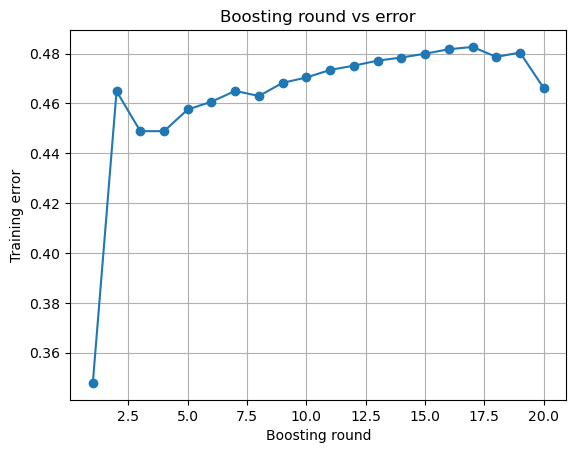

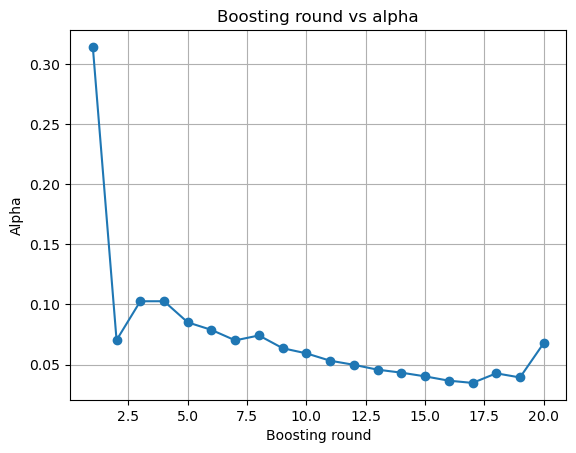

In [69]:
rounds = np.arange(1, len(errors) + 1)

plt.figure()
plt.plot(rounds, errors, marker="o")
plt.xlabel("Boosting round")
plt.ylabel("Training error")
plt.title("Boosting round vs error")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(rounds, alphas, marker="o")
plt.xlabel("Boosting round")
plt.ylabel("Alpha")
plt.title("Boosting round vs alpha")
plt.grid(True)
plt.show()


Q3 PART D

In [75]:
base_stump = DecisionTreeClassifier(max_depth=1, random_state=42)

ada_sklearn = AdaBoostClassifier(
    estimator = base_stump,
    n_estimators = 100,
    learning_rate = 1.0,
    algorithm = "SAMME"
)

ada_sklearn.fit(X_train, y_train)

y_train_pred_sklearn = ada_sklearn.predict(X_train)
y_test_pred_sklearn = ada_sklearn.predict(X_test)

print("Part D - Sklearn AdaBoost")
print("Train accuracy:", accuracy_score(y_train, y_train_pred_sklearn))
print("Test accuracy:", accuracy_score(y_test, y_test_pred_sklearn))
print("\nTrain confusion matrix:\n", confusion_matrix(y_train, y_train_pred_sklearn))
print("\nTest confusion matrix:\n", confusion_matrix(y_test, y_test_pred_sklearn))

print("\nComparison with Manual AdaBoost T=20")
print("Manual → Train:", train_acc_boost, " Test:", test_acc_boost)
print("Sklearn → Train:", accuracy_score(y_train, y_train_pred_sklearn),
      " Test:", accuracy_score(y_test, y_test_pred_sklearn))


Part D - Sklearn AdaBoost
Train accuracy: 0.6976115183590283
Test accuracy: 0.6969166104190956

Train confusion matrix:
 [[383176  55829]
 [174145 147375]]

Test confusion matrix:
 [[164210  23936]
 [ 74851  62943]]

Comparison with Manual AdaBoost T=20
Manual → Train: 0.696132277045462  Test: 0.69539792599865
Sklearn → Train: 0.6976115183590283  Test: 0.6969166104190956
